### IMPORT DATA

In [9]:
import numpy as np
import json
import pandas as pd

In [20]:
with open("/apdcephfs_qy3/share_301372554/share_info/ruihanyang/LoGU-followup/results/mistral-7b_repeat1_words100_knowledge_eval_facts_veracity.jsonl") as f:
    results = []
    for line in f:
        results.append(json.loads(line))

## Words

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/apdcephfs_qy3/share_301372554/share_info/ruihanyang/huggingface_models/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a")

/root/miniconda3/envs/uncertainty-expression/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
cnt = []
for item in results:
    cnt.append(len(tokenizer.encode(item["answers"][0])))

In [22]:
np.mean(cnt)

143.48074534161492

### Factuality

不同维度的 **频率** 和 **准确率**

In [63]:
frequency = {}
long_accuracy = {}
for item in results:
    for property, veracity in zip(item["properties"], item['veracity_labels'][0]):
        frequency[property] = frequency.get(property, 0) + 1
        if veracity=="S":
            long_accuracy[property] = long_accuracy.get(property, 0) + 1
        else:
            long_accuracy[property] = long_accuracy.get(property, 0)

In [55]:
# 创建 DataFrame
df = pd.DataFrame({
    'Aspect': frequency.keys(),
    'Frequency': frequency.values(),
    'Correct': [long_accuracy.get(property, 0) for property in frequency.keys()]
})

# 计算准确率
df['Accuracy'] = df['Correct'] / df['Frequency']

print(df)

                           Aspect  Frequency  Correct  Accuracy
0                   date of birth        480       66  0.137500
1                languages spoken        314      134  0.426752
2                          gender        472      443  0.938559
3                      occupation        446      209  0.468610
4           graduation university        238       18  0.075630
5                         IMDb ID        233        0  0.000000
6                  place of birth        440      112  0.254545
7          country of citizenship        470      305  0.648936
8                     Freebase ID        418        0  0.000000
9                    notable work         20        5  0.250000
10                         spouse        117       44  0.376068
11                 award received         96       12  0.125000
12                 place of death         91       20  0.219780
13                  date of death        122       16  0.131148
14  member of any political party       

/tmp/ipykernel_1550303/2786988229.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Aspect', y='Frequency', data=df, palette='Blues_d')


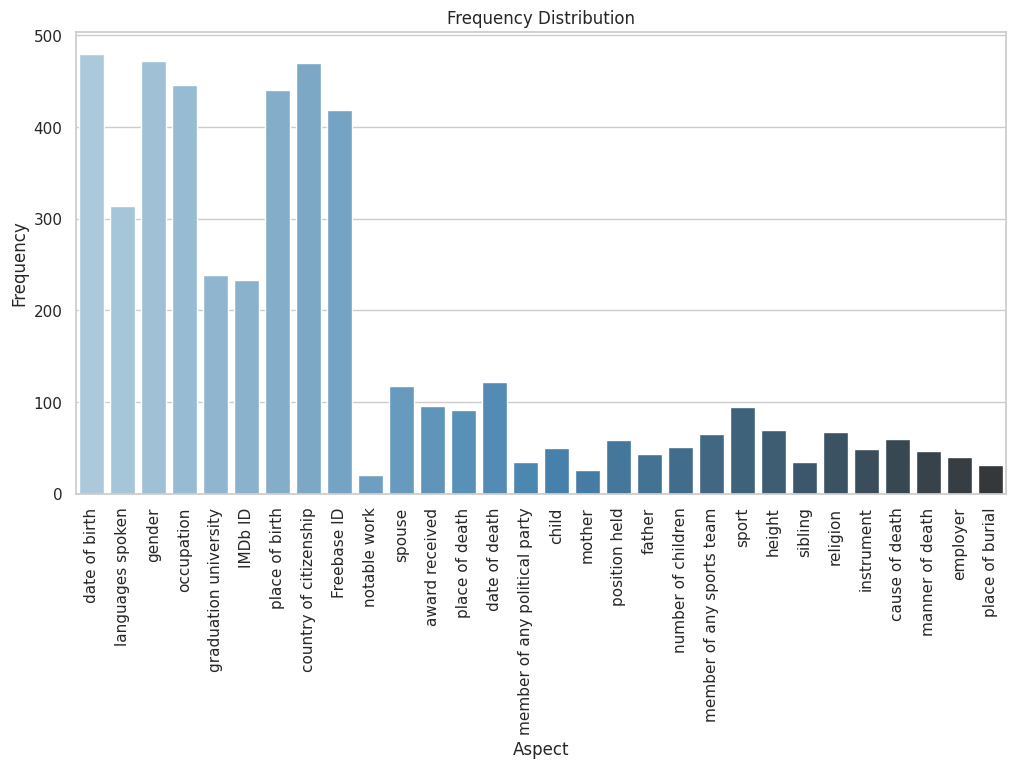

/tmp/ipykernel_1550303/2786988229.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Aspect', y='Correct', data=df, palette='Greens_d')


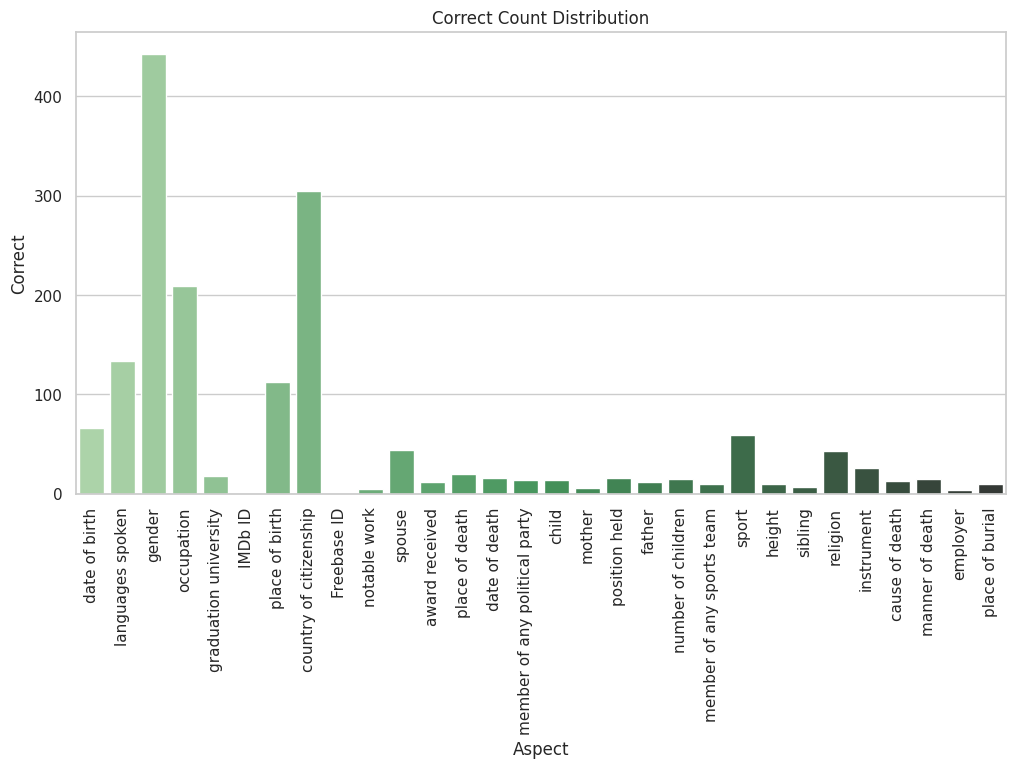

/tmp/ipykernel_1550303/2786988229.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Aspect', y='Accuracy', data=df, palette='Reds_d')


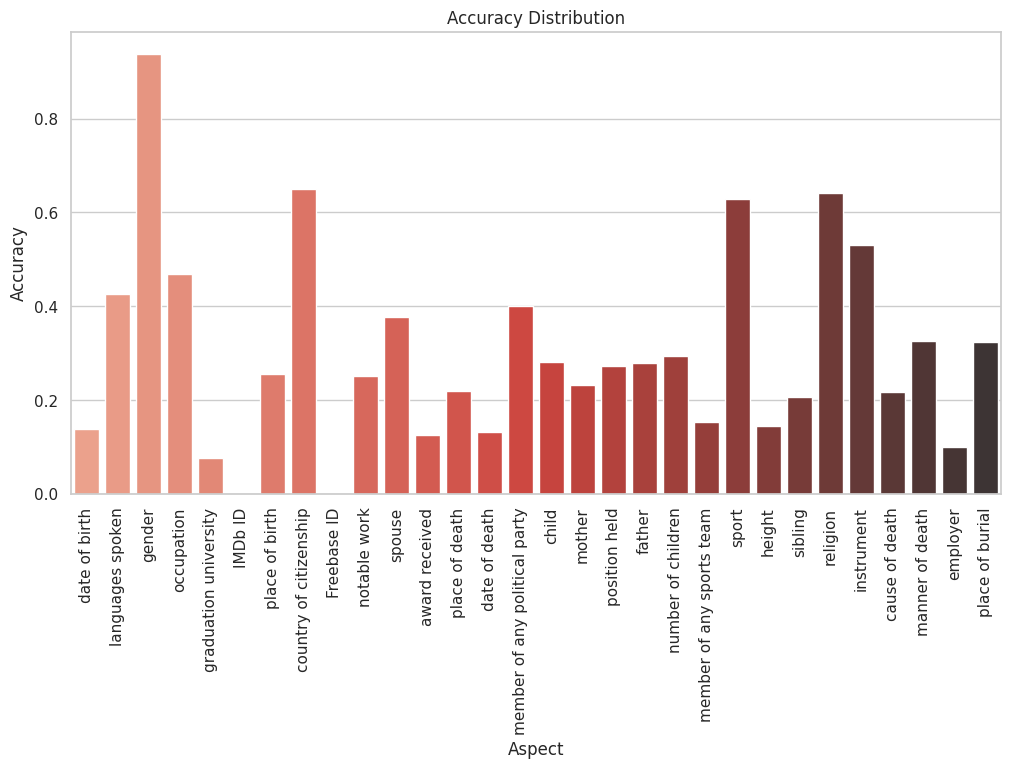

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置Seaborn样式
sns.set(style="whitegrid")

# 绘制频数分布柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x='Aspect', y='Frequency', data=df, palette='Blues_d')
plt.xlabel('Aspect')
plt.ylabel('Frequency')
plt.title('Frequency Distribution')
plt.xticks(rotation=90)
plt.show()

# 绘制正确个数分布柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x='Aspect', y='Correct', data=df, palette='Greens_d')
plt.xlabel('Aspect')
plt.ylabel('Correct')
plt.title('Correct Count Distribution')
plt.xticks(rotation=90)
plt.show()

# 绘制准确率分布柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x='Aspect', y='Accuracy', data=df, palette='Reds_d')
plt.xlabel('Aspect')
plt.ylabel('Accuracy')
plt.title('Accuracy Distribution')
plt.xticks(rotation=90)
plt.show()

**模型短问答Known的问题在长问答当中,是不是更容易说对 (greedy decoding)**

In [23]:
long_known = []
short_known = []
for item in results:
    long_known.append(item['veracity_labels'][0].count("S")/len(item["veracity_labels"][0]) if item["veracity_labels"][0] else 0)
    short_known.append(item['individual_veracity_labels'][0].count("S")/len(item["individual_veracity_labels"][0]) if item["individual_veracity_labels"][0] else 0)

In [24]:
np.mean(long_known), np.mean(short_known)

(0.32111801242236027, 0.362111801242236)

In [43]:
long_veracity, short_veracity = [], []
for item in results:
    if len(item['veracity_labels'][0]) == len(item['individual_veracity_labels'][0]):
        long_veracity.extend(item['veracity_labels'][0])
        short_veracity.extend(item['individual_veracity_labels'][0])

In [11]:
import pandas as pd
from sklearn.metrics import confusion_matrix


In [45]:
# 创建 DataFrame
df = pd.DataFrame({'A': short_veracity, 'B': long_veracity})

# 计算混淆矩阵
cm = confusion_matrix(df['A'], df['B'], labels=['S', 'NS'])

# 将混淆矩阵转换为 DataFrame
cm_df = pd.DataFrame(cm, index=['S', 'NS'], columns=['S', 'NS'])

print(cm_df)

       S    NS
S   1279   399
NS   201  1987


In [46]:
# 对混淆矩阵进行归一化
cm_normalized = cm_df / cm_df.values.sum()

print(cm_normalized)

           S        NS
S   0.330833  0.103207
NS  0.051992  0.513968


### Uncertainty

In [159]:
import json
import pandas as pd
model_id = "mistral-7b"
method = "repeat1_logu-sft_knowledge_eval"
with open(f"/apdcephfs_qy3/share_301372554/share_info/ruihanyang/LoGU-followup/results/{model_id}_{method}_facts_veracity.jsonl") as f:
    results = []
    for line in f:
        results.append(json.loads(line))

In [160]:
with open(f"/apdcephfs_qy3/share_301372554/share_info/ruihanyang/LoGU-followup/results/{model_id}_repeat1_knowledge_eval_facts_veracity.jsonl") as f:
    labels = []
    for line in f:
        labels.append(json.loads(line))

In [161]:
veracity_labels, known_labels = [], []
for result, label in zip(results, labels):
    if len(result['veracity_labels'][0]) == len(label['individual_veracity_labels'][0]):
        veracity_labels.extend(result['veracity_labels'][0])
        known_labels.extend(label['individual_veracity_labels'][0])

In [162]:
# 创建 DataFrame
df = pd.DataFrame({'A': known_labels, 'B': veracity_labels})

# 计算混淆矩阵
cm = confusion_matrix(df['A'], df['B'], labels=['S', 'NS', 'UNC'])

# 将混淆矩阵转换为 DataFrame
cm_df = pd.DataFrame(cm, index=['S', 'NS', 'UNC'], columns=['S', 'NS', 'UNC'])

print(cm_df)

        S    NS  UNC
S    1138   404  160
NS    187  1650  435
UNC    74   503  225


In [163]:
acc = cm_df['S'].sum()/(cm_df['S'].sum() + cm_df['NS'].sum())
unc_precision = cm_df['UNC']['NS']/(cm_df['UNC']['NS'] + cm_df['UNC']['S'])
unc_recall = cm_df['UNC']['NS']/(cm_df['UNC']['NS'] + cm_df['NS']['NS']+ cm_df['S']['NS'])

In [164]:
print(acc, unc_recall, unc_precision)

0.35364004044489383 0.1914612676056338 0.7310924369747899
